<a href="https://colab.research.google.com/github/janchorowski/ml_uwr/blob/fall2020/lectures/10_neuralnets_kernels_svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning @ UWr 2020

**Lecture 10**

During the last lecture we have seen how XGBoost builds ensembles of trees. The final model implemented the following formula:

$$
F_T(x) = \sum_{t=1}^T f_t(x)
$$

where $f_t$ are trees that map samples $x$ to values stored in the tree leaves. 

The model can be interpreted as performing two operations:
1. $x$ is nonlinearly transformed into a vector of 0/1 indicator variables, each denoting the presence or absence of $x$ i a given tree leaf.
2. The indicator variables are linearly transformed to produce the model output.



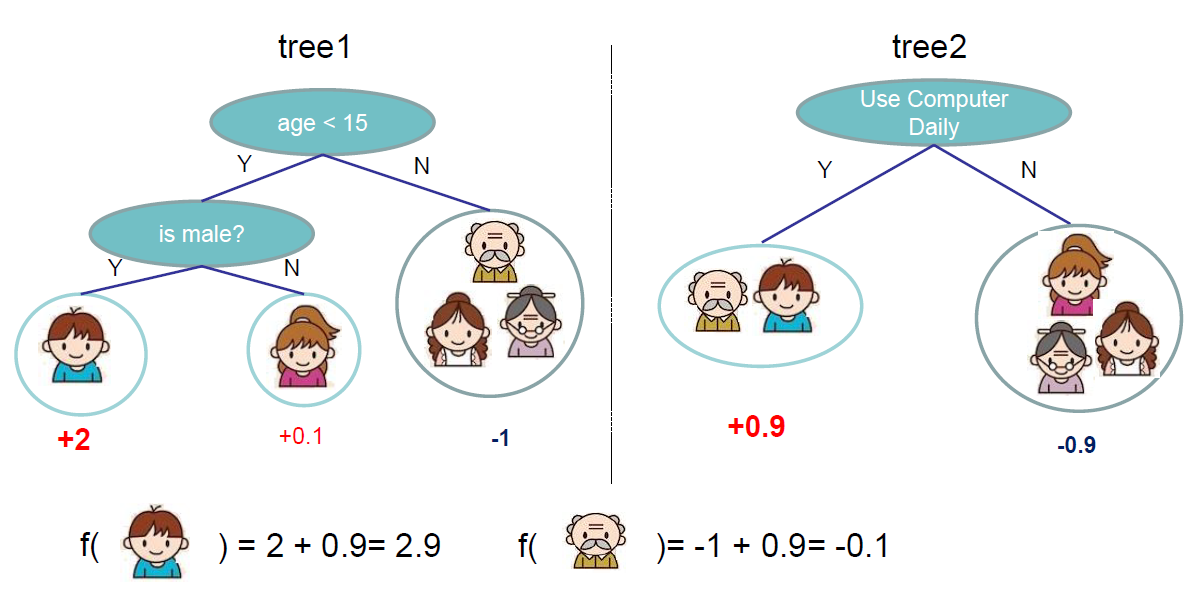

[From T.Q Chen's XGBoost presentation]

Under this interpretation, XGBoost learns a representation of samples in which linear models work well. 

We have already seen one other model that relied on linear combination of features extracted from data: the polynomial regression. Again, it processed samples in two steps:
1. map an $x\in\mathbb{R}$ to a vector of its powers: $x \rightarrow [1, x, x^2, x^3, ...]$.
2. linearly combine the powers of $x$ (the extracted features).

In this lecture we will explore two other ways of feature extraction:
1. Neural networks learn a series of non-linear data transformations, followed by a prediction layer (e.g. SoftMax).
2. Kernel methods apply a fixed data transformations that expand its dimensionality to such a degree, that linear models work well.

Finally, we will introduce a model that works great with kernel-based feature expansion: the Support Vector Machine (SVM). SVMs will also expose us to the concept of Maximal Margins, a notion of model complexity which has been also used to explain the generalization performance of boosting.

Please note, that dut to course length constraints this set of lecture notes is presented at a very intuitive level. We apologize for this lack of depth and direct the curious reader to textbooks, such as Bishop, or lecture notes from e.g. [CS229](http://cs229.stanford.edu/).

## Intuitions about Neural Networks and Deep Learning

We will show here a very simple neural network. If you would want to learn more, please enroll into my course ["Neural Networks and Deep Learning"](https://github.com/janchorowski/dl_uwr).

Please recall the logistic regression classifier. It takes a sample $x\in \mathbb{R}^D$ and classifies it by checing the sign of $x\Theta + b$, which can be interpreted as separating the two classes with a line determined by the vector $\Theta$:

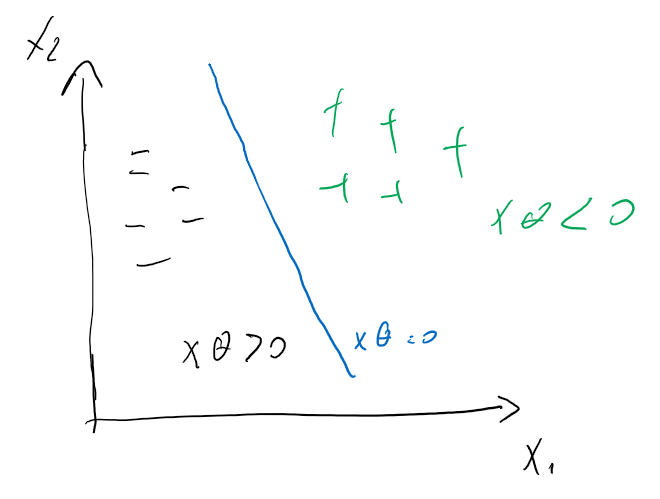

Logistic Regression is a nice, simple, and undertandable model. However, it has limited capacity to fit the training data. For instance, it can't solve the XOR problem:

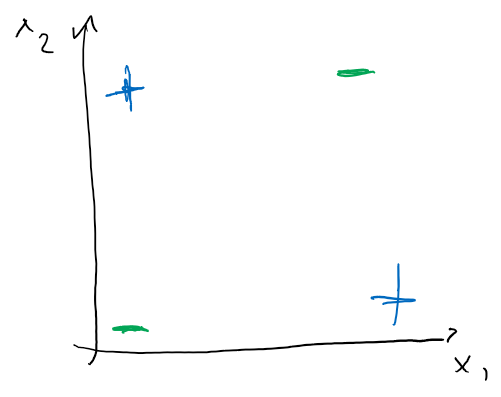

Let's write down the XOR dataset:

$x_1$ | $x_2$ | $y$
:----:|:-----:|:---:
0 | 0 | 0 
0 | 1 | 1
1 | 0 | 1
1 | 1 | 0

Suppose we apply to $x$ a feature transformation:
$$
[x_1, x_2] \rightarrow [x_1 \text{ OR } x_2, x_1 \text{ AND } x_2]
$$
The transformed data is linearly separable:

$x_1$ | $x_2$ | $x_1$ OR $x_2$ | $x_1$ AND $x_2$ | $y$
:----:|:-----:|:--------------:|:----------------:|:---:
0 | 0 | 0 | 0 | 0 
0 | 1 | 1 | 0 | 1
1 | 0 | 1 | 0 | 1
1 | 1 | 1 | 1 | 0


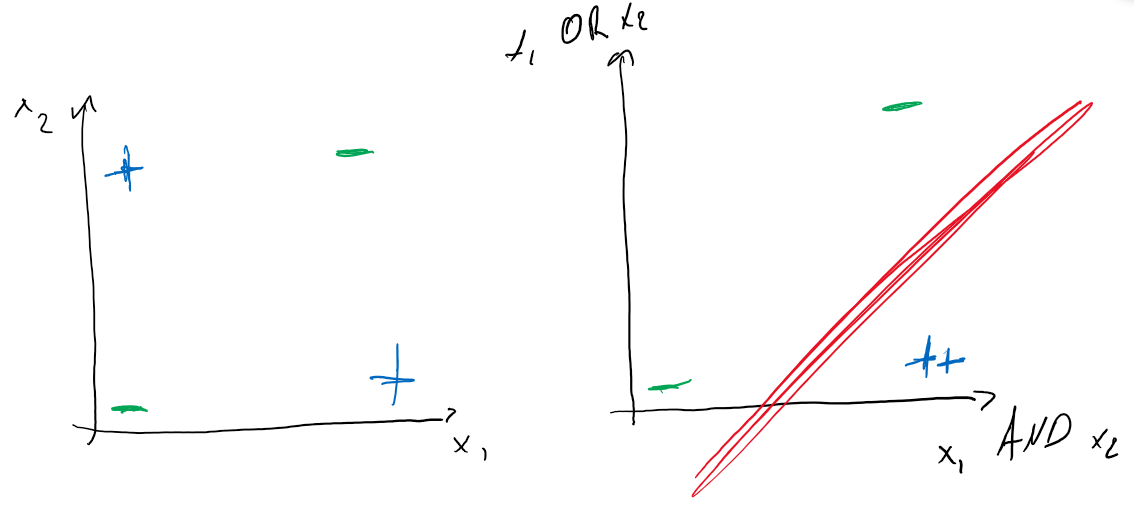

Observation: AND and OR functions can be computed by:
- linearly projecting the data
- applying a nonlinearity (e.g. a threshold operation)

$$
x \text{ OR } y = [x + y > 0.5] \\
x \text{ AND } y = [x + y > 1.5]
$$
where $[]$ is the indicator function.

Thus, our XOR model could work as follows:
- linealry project the data
- apply nonlinearities
- linearly separate the two classes

We could present this model graphically like that:

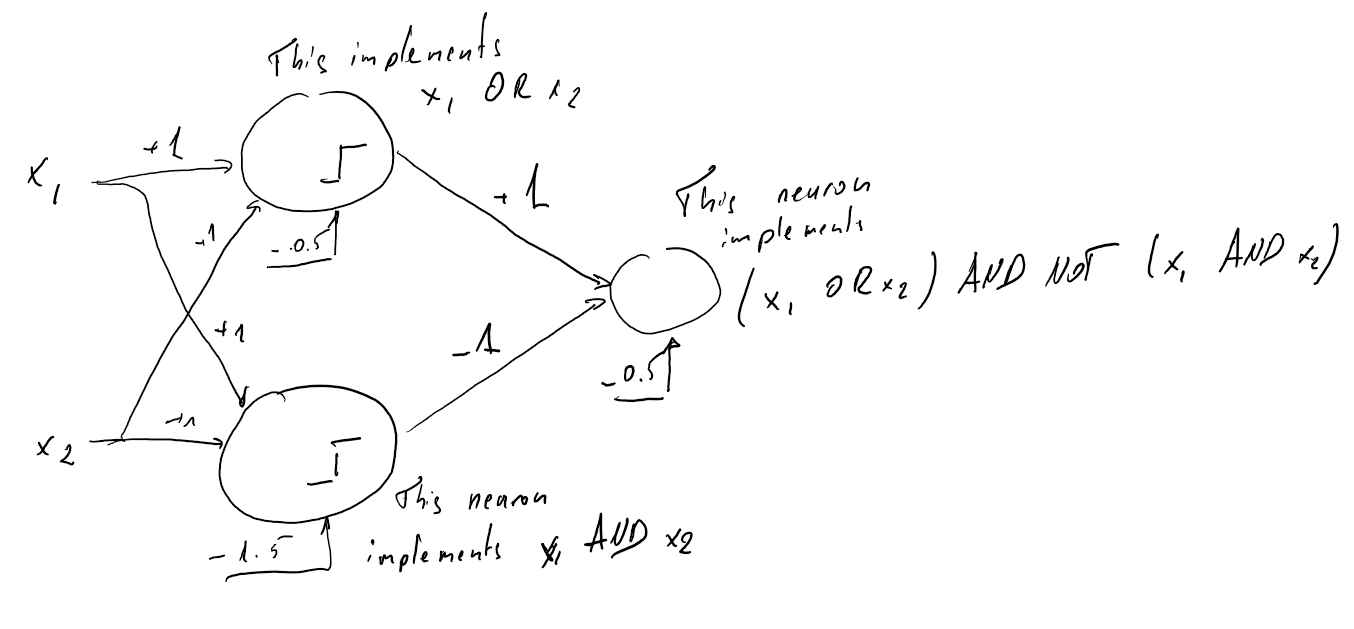

We call such model an _artificial neural network_. Artificial neurons are simple computing units which take a linear combination of their inputs and apply a nonlinear transformation (a so called activation function). A network of neurons is called, a neural network.

## Training of neural networks

The neural network presented above has one drawback: it can't be trained! We have invented its parameters (weights and biases), however we have no simple procedure of fitting them to the data (genetic or evolutionary algorithms, shold work for simple networks, but gradient-based methods work better for large ones). This limitation has a very simple reason:
our activation functions are non-differentiable!

We will make one small change to our network and replace the hard threshold activation function with a smooth approximation, such as the logistic sigmoid. This change makes the neural network amenable to gradient-based optimization. using it we can fit all parameters (the weights in the feature transformation and in the output combination) jointly to optimize a loss function. The network simultaneously discovers features and the separating hyperplane!

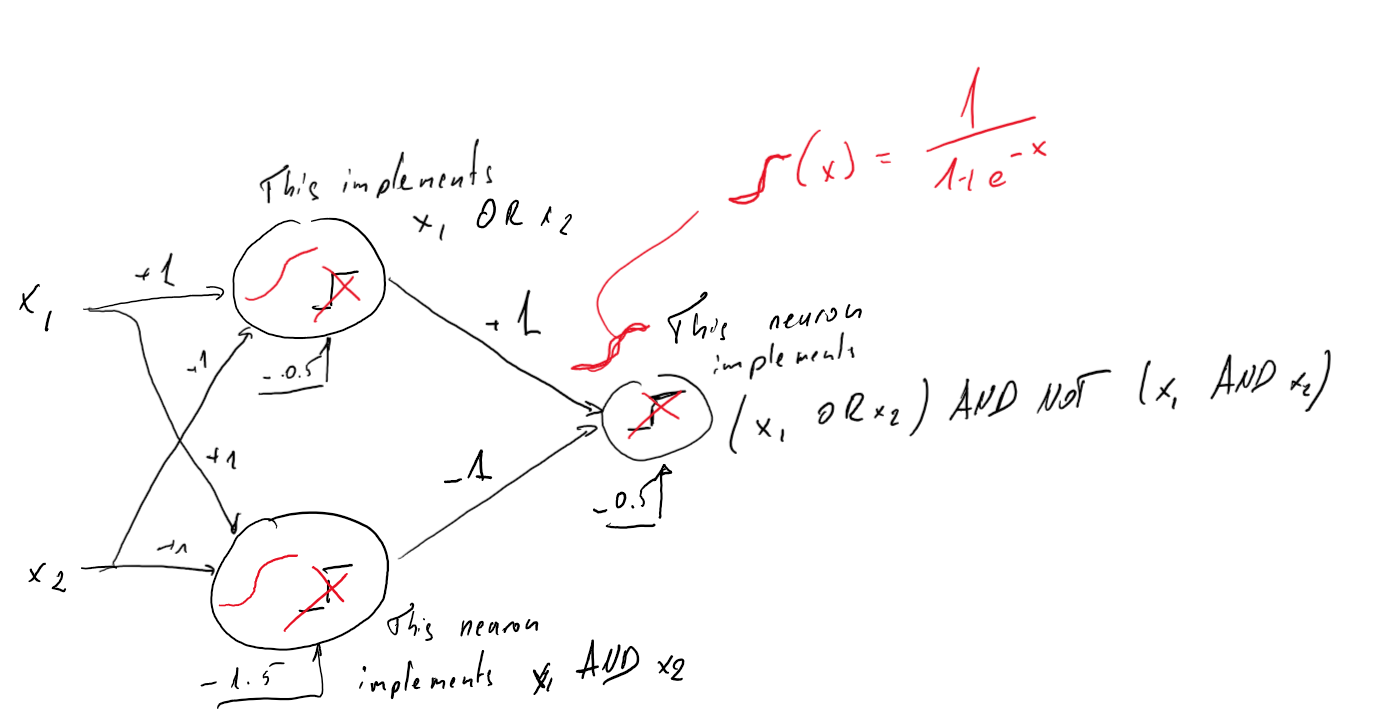

### Neural network demonstration

We will now perofrm a small demonstration of the XOR network

In [12]:
import torch
import torch.nn.functional as F
torch.manual_seed(42)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
X = torch.tensor(
    [[0, 0],
     [0, 1],
     [1, 0],
     [1, 1]], dtype=torch.float)

Y = torch.tensor(
    [[0], [1], [1], [0]], dtype=torch.float)

# Weights and biases of the learnable feature extractor
NUM_NEURONS = 2
Wf = torch.zeros(X.shape[1], NUM_NEURONS, requires_grad=True)
bf = torch.zeros(NUM_NEURONS, requires_grad=True)

# Weight and bias of the output projection
Wo = torch.zeros(NUM_NEURONS, 1, requires_grad=True)
bo = torch.zeros(1, requires_grad=True)

params = [Wf, bf, Wo, bo]

# Randomly initialize the weight matric
with torch.no_grad():
    Wf[...] = torch.randn(*Wf.shape)
    Wo[...] = torch.randn(*Wo.shape)

# Do a few gradient descent steps
alpha = 1
for step in range(2000):
    features = torch.sigmoid(X @ Wf + bf)
    output = features @ Wo + bo
    loss = F.binary_cross_entropy_with_logits(output, Y)
    if (step % 200) == 0:
        print(
            f"step: {step}, loss: {loss.item()} "
            f"acc: {((output>0) == Y).float().mean().item()}")
    loss.backward()
    
    with torch.no_grad():
        for p in params:
            p -= alpha * p.grad
            p.grad.zero_()

step: 0, loss: 0.7612034678459167 acc: 0.5
step: 200, loss: 0.6931622624397278 acc: 0.5
step: 400, loss: 0.6931366920471191 acc: 0.5
step: 600, loss: 0.6931180953979492 acc: 0.5
step: 800, loss: 0.6930738091468811 acc: 0.5
step: 1000, loss: 0.6928442120552063 acc: 0.75
step: 1200, loss: 0.6866856813430786 acc: 0.75
step: 1400, loss: 0.4582027196884155 acc: 0.75
step: 1600, loss: 0.07428639382123947 acc: 1.0
step: 1800, loss: 0.03142259642481804 acc: 1.0


In [3]:
print(f"Wf={Wf.detach()}")
print(f"bf={bf.detach()}")

print(f"Wo={Wo.detach()}")
print(f"bo={bo.detach()}")

Wf=tensor([[4.4945, 6.4126],
        [4.4946, 6.4129]])
bf=tensor([-6.8840, -2.8155])
Wo=tensor([[-10.1550],
        [  9.4216]])
bo=tensor([-4.2937])


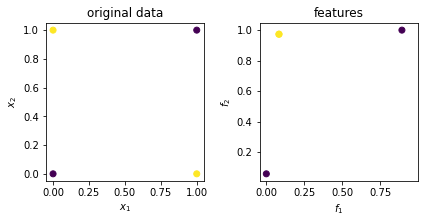

In [4]:
plt.subplot(1, 2, 1)
plt.scatter(X[:,0], X[:,1], c=Y[:,0])
plt.axis('square')
plt.title('original data')
plt.xlabel('$x_1$'), plt.ylabel('$x_2$')

plt.subplot(1, 2, 2)
plt.scatter(features[:,0].detach(), features[:,1].detach(), c=Y[:,0])
plt.axis('square')
plt.title('features')
plt.xlabel('$f_1$'), plt.ylabel('$f_2$')

plt.tight_layout()

Please note how the two feature extracting neurons (which are typicalli calle dthe hidden neurons) have learned to approximate the _and_ and _or_ logic functions. Thus the network has learned, all by itself, a useful data transformation! This observation is the cornerstone of modern deep learning methods. While they employ models which are more sophisticated than the simple network above, they allso implement models which gradually, layer-by-layer, transform data from its raw form (e.g. raw image pixels) into features in which a simple SoftMax classifier can work. The whole model is tuned using gradient descent and useful data representations are discovered by the model.

## Kernel-based Feature expansion

We will now learn about another way to expand the data, this time using fixed, but highly (possibly infinitely) dimensional data transformations. We will start with a simple observation:

> The gradient of the loss on an axample $x$ with respect to the parameters of linear or logistic regression is a scaled $x$.

In fact, you may recall that for linear regression the gradient was
$$
\frac{\partial L(\Theta)}{\partial \Theta} = X^T\left(X\Theta-Y\right) = \sum_i (X^i)^Tc^i
$$ 
where $c$ are constants. Similarly, for logistic regression the gradient is:
$$
\frac{\partial L(\Theta)}{\partial \Theta} = X^T\left(\sigma(X\Theta)-Y\right) \sum_i (X^i)^Tc'^i
$$
where again $c'$ are constants.

If we start the gradient descent from a zero vector, the vector $\theta$ will always be a linear combination of training samples! Thus we can write the trained $\Theta$ as:
$$
\Theta = \sum_i\alpha^i (x^i)^T.
$$

This is a powerful observation: for many models, including linear and logistic regression, we can forget about $\Theta$ and instead wotk with the sample weigths $\alpha$. This may be beneficial for instance, if we have more dimensions that data samples.

Using the $\alpha$ form of the model has important implications on the way in which we are accessing the data. Consider first the application of a model to a new data sample:
$$
x\theta = x\left(\sum_i\alpha^i (x^i)^T\right) = \sum_i\alpha^i \left(x(x^i)^T\right) = \sum_i\alpha^i <x, x^i>,
$$
where $<u, v> = u v^T$ denotes the dot-product between the row vectors $u$ and $v$.

The above equation means, that when using the $\alpha$ parameterization of the model, we access data only through dot-products with other data samples.

This allows the use of kernel functions $K$. Intuitively, a kernel function is a smart way of computing dot-products of non-linearly transformed data. That is:
$$
K(u, v) = \phi(u) (\phi(v))^T = <\phi(u), \phi(v)>
$$
In other words, for a matched pair of a kernel function $K$ and a feature exansion function $\phi$ we have two ways of computing the dot-products on transformed data:
1. Apply the kernel function to raw data
2. Transform the data using $\phi$, then compute the dot-products.

If $phi$ projects the data into a highly-dimensional space, the kernel function approach may be significantly faster.





Let's see a motivating example.

Consider 1-dimensional data samples $u\in\mathbb{R}$ and $v\in\mathbb{R}$ and let $K(u, v) = (uv + 1)^3$.

Let's expand it to:
$$
\begin{split}
K(u, v) &= (uv + 1)^3 \\
&= 1 + 3uv + 3(uv)^2 + uv \\
&= 1\cdot 1 + \sqrt{3}u\cdot \sqrt{3}v + \sqrt{3}u^2\cdot \sqrt{3}v^2 + u^3\cdot v^3\\
&= \left[1, \sqrt{3}u, \sqrt{3}u^2, u^3 \right] \cdot \left[1, \sqrt{3}v, \sqrt{3}v^2, v^3 \right]^T \\
&= \phi(u) (\phi(v))^T,
\end{split}
$$
where $\phi(x) = [1, \sqrt{3}x, \sqrt{3}x^2, x^3]$.

In this example, the kernel function corresponds to a polynomial feature expansion (up to the $\sqrt{3}$ scaling constants). However, the kernel may be faster to compute.

Now consider that the data are two dimensional: $u=[u_1, u_2]$ and $v=[v_1, v_2]$. Again let $K(u, v) = (uv^T + 1)^2$ and expand:

$$
\begin{split}
K(u, v) &= (uv^T + 1)^2 = (u_1v_1 + u_2v_2 + 1)^2 \\
&= 1 + 2u_1v_1 + 2u_2v_2 + 2u_1v_1u_2v_2 + (u_1v_1)^2 + (u_2v_2)^2 \\
&= \left[1, \sqrt{2}u_1, \sqrt{2}u_2, \sqrt{2}u_1u_2, u_1^2, u_2^2 \right] \cdot \left[1, \sqrt{2}v_1, \sqrt{2}v_2, \sqrt{2}v_1v_2, v_1^2, v_2^2 \right]^T \\
&= \phi(u) (\phi(v))^T.
\end{split}
$$

Again, the kernel function induces a corresponding feature expansion. This time, the space savings are more apparent: we can compute the kernel using 3 multilications and 2 additions, while the dot-product in the expanded space costs us 5 multiplications and 5 additions, to which we must add the cost of the polynomial feature expansion. Needless to say, the computational savings grow when the data is more dimensional  and when we use a higher power in the kernel function.

The example has introduced us to the first general purpose kernel function, called the polynomial kernel $K_P$:

$$
K_p(u, v) = (uv^t + c)^d,
$$
where u,v are row-vectors, $d$ is the poynomial degree, and $c$ controls the relative influence of the low and high degree components. 

The use of the kernel function enforces the $\alpha$ formulation of the model. We never apply the feature expansions directly, and we thus never store nor directly learn the parameters $\theta$. Instead, we introduce the variables $\alpha^i$ and we optimize our loss function with respect to them. This has an important consequence: the size of our model (the number of $\alpha^i$s that we must store) grows with the dataset size! This is often beneficial anyway, because the dimensionality of the space into which $\phi$ places the data can grow very fast (consider a dataset with 100 raw features and the polynomialkernel with d=10)!

### Other popular Kernel Functions

The dot-product of two samplest measures how similar they are - it is larges if the two samples are the same up to scaling. Thus, intuitively, kernel functions should also capture some notion of sample similarity.

A case in point is the Gaussian Kernel defined as

$$
K_G(u,v) = e^{\frac{-||u-v||^2}{2\sigma^2}},
$$
where $\sigma$ is a parameter.

The Gaussian Kernel is large if the $u$ and $v$ samples are identical, then it rolls off to zero, with the speed of decrease controlled by the $\sigma$ parameter. 

The Gaussian Kernel intuitively leads to a nearest-neighbors behavior of the model: the samples which are near the query have large kernel values and hence the largest influence on the model's output.

For many domains, specialised kernel functions exist. Consider a text dataset, and define the kernel to be the number of common substrings. On the one hand, this corresponds to a feature expansions in which each feature denotes the presence of a given string over the alphabet. On the other hand, common substrings can be efficiently computed using many dynamic programming algorithms.

### Conditions for Valid Kernels

The remaining question is which functions are valid Kernel functions, that is which functions induce an expanded feature space with a dot-product equal to the kernel function application?

The answer is provided by the [Mercer's theorem](https://en.wikipedia.org/wiki/Mercer%27s_theorem): let $K$ be a symmetrical function on pairs of vectors, that is $K(u,v) = K(v,u)$. Then $K$ is a valid kernel function if and only if 

$$
\sum_{i=1}^N\sum_{j=1}^NK(x^i, x^j)c_i c_j \geq 0
$$

for all finite sequence of vectors $x^1,..., x^N$ and real numbers $c_1,...,c_n$.

In other words, the matrix obtained by applying the kernel to any dataset must be symmetric and positive semi-definite.

Intuitively, this reflects the properties of the dot-product. We will now only show that the Mercer condition is required for K to be a kernel. Suppose that K indices a transformation $\phi$. Then:
$$
\sum_{i=1}^N\sum_{j=1}^NK(x^i, x^j)c_i c_j  = \sum_{i=1}^N\sum_{j=1}^N\phi(x^i)\phi(x^j)^Tc_i c_j = \left(\sum_{i=1}^N c_i \phi(x^i)\right)\left(\sum_{j=1}^N c_j \phi(x^j)\right)^T = \left\|\left(\sum_{i=1}^N c_i \phi(x^i)\right)\right\|^2 \geq 0.
$$


## SVM introduction

Kernel methods allow the application of linear methods to non-linear settings. Their main advantages are:
- Kernel functions can be generic, or make use of domain knowledge.
- The resulting optimization prolem over $\alpha$ is often convex and can be solved efficiently. For instance, a closed-form formula exists for kernelized least squares.
The downside of Kernelized models is that their size, and also runtime, is proportional to the size of the training data, which can become prohibitively expensive. In this section we will learn about the SVM - a classifier which can be kernelized, and whose behavior depends only on a subset of training data, the so-called support vectors. 

We will define the SVM for a binary classification task. So far our reasoning in such case was as follows:
1. define a model which computes $p(y|x)$,
2. introduce a loss function, typically use negative log-likelihood along with some regularization,
3. minimize the loss function.

The inventors of SVM claimed, that this is not the moset efficient way of solving this problem, beause we are interested in a simple problem (a decision boundry which separates the two classes) yet we solve a harder one (modeling of the conditional probability). Thus, they proposed a model which introduces the best linear boundary between the two classes, defined to be the boundary with maximal distance to training data samples.

Let's analyze this on an example.


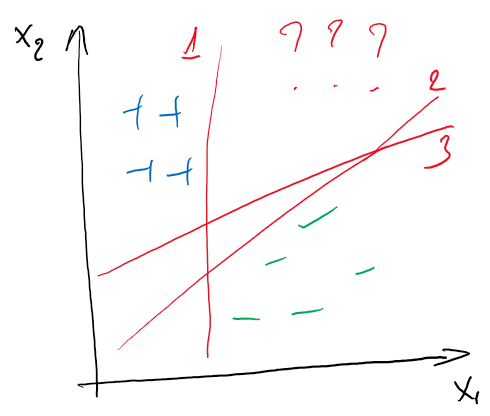

Which of the three red separating lines is better? Lines "1" and "2" pas near data samples, whilt the line "3" is further away.

Let's formalize this notion. We will deal with a two-class classificatoin task, encoding the targets $y$ as $\pm1$. For now we will assume that the classes are linearly separable, and our main and only task is to find the best, most distanced from all training samples separating hyperplane given by the formula $x\theta + b = 0$. Notice, that in this case we keep the ias term $b$ explicit. When we solve this case, we will approach the nonlinearly separable case and get intuitions about the use of kernels for non=linear classification.

Define the **margin** of a separating hyperplane $x\theta + b$ as the distance of the closest training point to the hyperplane:

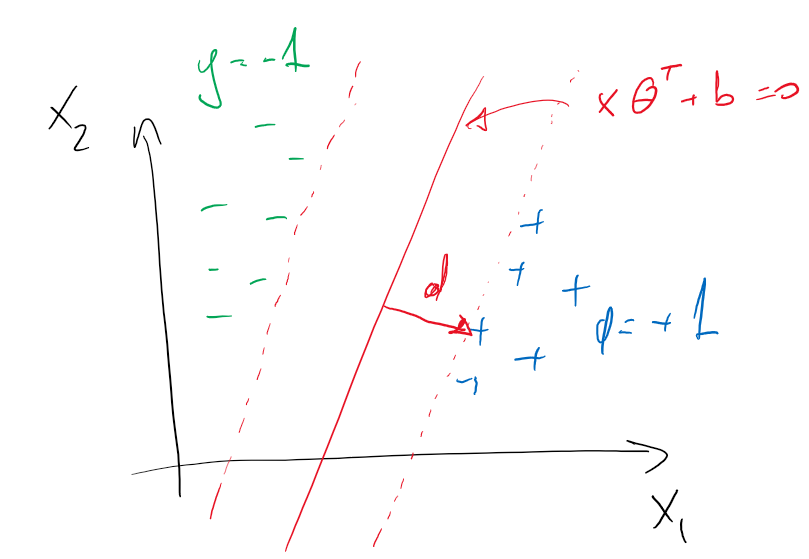

The data has two features: the separating hyperplane is given by the equation $x\theta + b = $. The two dotted lines indicate the margin: there are no training samples between them. the signed distance $d$ can be computed using the formula:

$$
d = \frac{x\theta + b}{\|\theta\|}
$$

We want to find parameters $\theta$ and $b$ such that the margin width $d$ is maximized, and all training samples lie more than $d$ away from the hyperplane. Formally, finding the best hyperplane is equvalent to solving the optimization problem
$$
\begin{split}
\max_{d, \theta, b} &\; d \\
\text{sjt: } & \frac{x^i\theta + b}{\|\theta\|} \geq d\; \forall i: y^i =1 \\
& \frac{x^i\theta + b}{\|\theta\|} \leq -d\; \forall i: y^i =-1,
\end{split}
$$
where sjt means "subject to", $d$ is the signed distance of points to separating boundary and we make sure that training data are at appropriate sides of the boundary.

We will first simplify the contraints, by making use of the fact that $y\in\pm1$:

$$
\begin{split}
\max_{d, \theta, b} &\; d \\
\text{sjt: } & y^i(x^i\theta + b) \geq d\|\theta\|\;\forall i
\end{split}
$$

However, this problem is impossible to solve because we have too much modelling freedom: units in which we measure $d$ are arbitrary, and we can trivially maximize $d$ by making $\theta$ small. This doesn't affect the location of the separation boundary, because it depends only on the direction of $\theta$, and not on its magnitude. Lets fix this by adding the scale constraint $d\|\theta\|=1$. 

To get intuitions about this new constraint note, that the margin width $d$ is equal to the number of $\|\theta\|$-long stepsthat we take along the vector $\theta$ (recall that it is perpendicular to the separating plane) to reach a training point. We can fix $\|\theta\|$ and maximize $d$, or we can fix $d$ and minimize $\|\theta\|$. Our constraint folows the second approach.

By applying the extra constraint $d\|\theta\|=1$ we can remove $d$ from the optimization problem:
$$
\begin{split}
\max_{\theta, b} &\; \frac{1}{\|\theta\|} \\
\text{sjt: } & y^i(x^i\theta + b) \geq 1
\end{split}
$$

We will make one more transformation of our training criterion: rather than maximizing $\frac{1}{\|\theta\|}$, we will minimize $\|\theta\|^2 = \theta^T\theta$. Our final training objective is thus:

$$
\begin{split}
\min_{\theta, b} &\; \theta^T\theta \\
\text{sjt: } & y^i(x^i\theta + b) \geq 1\; \forall i
\end{split}
$$

We have thus formalized the problem of findinx the max-margin separating hyperplane to finding a hyperplane with minimal weights $\theta$ which keeps all samples at least 1 unit away.



### SVM boundary depends on a few data points.

While an exact derivation of a solution to the SVM optimization problem is outside the scope of these lecture notes (we direct the interested reader to the lecture notes for [CS229](http://cs229.stanford.edu/)), we will show below some intuitions about the optimal solution.

We first observe, that the problem has one constraint for each training sample. For a given $\theta$ and $b$ we can however divide the constraints into two groups:
1. _inactive_ constraints for which $y^i(x^i\theta + b) > 1$,
2. _active_ ones for which $y^i(x^i\theta + b) = 1$.

The inactive constraints can be omitted, the decision boundary is controlled only by the _closest_ training samples, the ones right at the edge of the margin. We call them the **support vectors**, because they support the decision boundary.

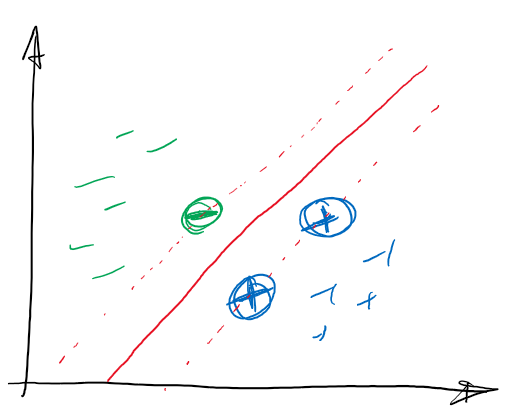

On the image above the three marked data samples are the support vectors. They fully specify the decision boundary. The location of the other samples is not important, as long as they are not crossing the margin boundary.

### Trading training errors for a wide margin

We will now lift the restriction on linear separability of the training dataset and introduce a general mechanism of for traiding off a wide margin for some training errors. Consider the datset pictured below.

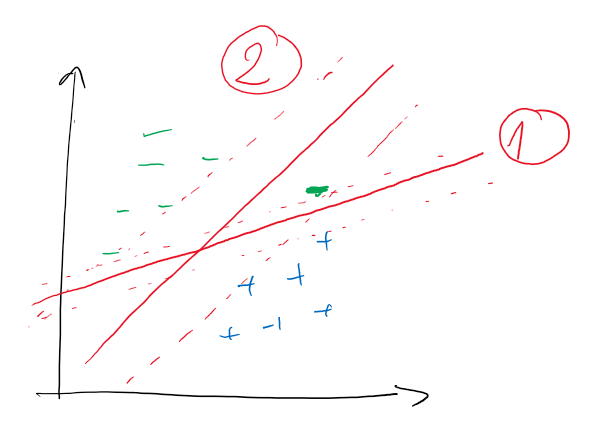

The max-margin separating hyperplane is the line "1". It separates all trainign samples and is forced to lie close th the training samples because of the lone negative examples near the positive region. This single negative sample could just as well be an outlier! It's removal would yield the decision boundary "2", which has a much wider margin.

If we allow any outliers, or label noise, or ambiguity in labeling, the solution "2" may be preferred to "1": whie it makes one training mistake (it puts the lone $-$ into the $+$ zone), it has a wide margin. Thus we may prefer to trade off the margin width for a non-perfect training acurracy. Let's formalize this by chaning the SVM optimizatoin problem into the so-called "soft margin" variant:

$$
\begin{split}
\min_{\theta, b, 
\epsilon^i} &\; \theta^T\theta + C\sum_i\epsilon^i\\
\text{sjt: } & y^i(x^i\theta + b) \geq 1-\epsilon_i\; \forall i \\
& \epsilon_i \geq 0\;\forall i
\end{split}
$$

We have introduced new variables, $\epsilon^i$ which capture for each sample its margin violation. If the sample $i$ is outside the margin, $\epsilon^i=0$ and and the margin constraint is inactive: $y^i(x^i\theta + b) > 1$ . However, if a sample falls inside the margin, or even is on the wrong side of the classification boundary, then: $\epsilon^i>0$, which means and the margin constraint is active $y^i(x^i\theta + b) = 1-\epsilon^i$. The tradeoff between a perfect separattion and margin size is controlled by the constant $C$: if $C$ is large, we don't allow samples inside the margin and strive for a perfect classification. If, on the other hand, $C$ is small, we allow a few trainign mistakes, as long as they allow a large margin (small $\|\theta\|$).

To get some further insights into the operation of the soft-margin constrint, lets observe that:
1. $\epsilon^i \geq 0$
2. $\epsilon^i \geq 1 - y^i(x^i\theta + b)$
3. at the optimal point $\epsilon^i$ is as small as possible, i.e. $\epsilon^i = \max(0, 1 - y^i(x^i\theta + b))$.

These observations allow us to rewrite the soft-margin optimization task as an unconstrained optimization problem:
$$
\min_{\theta, b} \; \theta^T\theta + C\sum_i \max(0, 1 - y^i(x^i\theta + b)).
$$

This optimization target should look familiar! It has two terms, balanced by a constant $C$:
1. $\sum_i \max(0, 1 - y^i(x^i\theta + b))$ adds up th emargin violations, or in other words it measures the fit to th etraining data. The smaller its value, the better the fit.
2. $\theta^T\theta$ is the familiar weight-decay or L2 regularization!

Thus we have found a connection between the SVM and the classifiers we already know such as logistic regression! To understand their similarities and differences, lets compare their loss functions:



Text(0, 0.5, 'Loss')

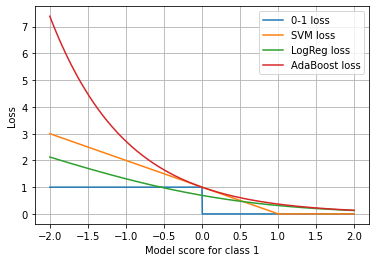

In [9]:
x = np.linspace(-2, 2, 1001)
plt.plot(x, x<=0, label='0-1 loss')
plt.plot(x, np.maximum(0, 1-x), label='SVM loss')
plt.plot(x, np.log(1+np.exp(-x)), label='LogReg loss')
plt.plot(x, np.exp(-x), label='AdaBoost loss')
plt.legend()
plt.grid()
plt.xlabel("Model score for class 1")
plt.ylabel("Loss")

By inspecting the loss functions we can see, that:
- All losses approach 0 for confidently and correctly classified samples. The 0-1 and SVM losses exactly reach 0, LogReg and AdaBoost losses have an asymptote at 0.
- The 0-1 loss is zero whenever a correctly classified sample barely crosses the classificatoin bundary. All other losses only gradually reach 0. This promotes large margins even if a sample is correctly classified, the loss is reduced by moving the decision boundary further away. 
- The 0-1 loss saturates at 1 for incorrectly classified samples. SVM and Logistic Regression losses grow linearly with the the distance of a misclassified sample from the decision boundary, while the exponential loss grows exponentially fast.
- Only the LogReg loss is induced by a probability distribution. By design, the SVM doesn't fit a probability distribution, however one can be obtained post-hoc using the technique of [Platt Scaling](https://en.wikipedia.org/wiki/Platt_scaling).

Finally, we observe that the optimal soution ot the SVM loss only depends on the samples that are incorrectly classified or within the margin, that is the samples with non-zero loss. Inuitively, samples with the zero loss can be moved by a tiny amount and the loss doesn't change, hence they don't directly influcence it, and they are not used to set the decision boundary. On the other hand, the LogReg loss depends on all the samples, and moving even the most confidently and correctly classified sample by a tiny bit will have a slight effect on the loss.

This property is important when kernel functions are used to obtain non-linear variants of the models. It can be shown, that in an SVM the optimal weights $\theta$ are once again a linear combination of trainign samples:

$$
\theta_{SVM}= \sum_i\alpha_i x^i
$$

It can be shown that the $\alpha$'s are the Lagrange multipliers associated with the margin constraints. Moroever, they lie in the range $0\leq \alpha^i \leq C$ and they are nonzero only for the support vectors. This is especially desirable for the kernelized variant of the SVM: to evaluate the classifier we no longer need access to the whole training set, but only to the support vectors. Note however, that usually the number of support vectors is a fractoin og the training set size.

Let's now see the SVM in action!



In [61]:
#@ Utility functions

def plot_data(X, Y, W=None, XGrid=None, YGrid=None):
    pal2 = sns.color_palette("Set1")[:2]
    if XGrid is not None:
        plt.contourf(
            XGrid[0],
            XGrid[1],
            YGrid.reshape(XGrid[0].shape),
            cmap="Set1",
            vmin=-1,
            vmax=9,
            alpha=0.5,
        )
    sns.scatterplot(x=X[:, 0], y=X[:, 1], size=W, hue=Y, 
                    palette=pal2, edgecolors='white', linewidths=2)
    plt.axis("square")
    if XGrid is None:
        plt.xlim(X[:, 0].min() - 0.1, X[:, 0].max() + 0.1)
        plt.ylim(X[:, 1].min() - 0.1, X[:, 1].max() + 0.1)
    else:
        plt.xlim(XGrid[0].min() - 0.1, XGrid[0].max() + 0.1)
        plt.ylim(XGrid[1].min() - 0.1, XGrid[1].max() + 0.1)
    

    # Remove size from legend
    ax = plt.gca()
    # EXTRACT CURRENT HANDLES AND LABELS
    h, l = ax.get_legend_handles_labels()

    # COLOR LEGEND (FIRST 30 ITEMS)
    col_lgd = plt.legend(h[:2], l[:2], loc="upper right")

def get_grid(X):
    Grid = np.meshgrid(
        np.linspace(X[:, 0].min() - 0.1, X[:, 0].max() + 0.1, 50),
        np.linspace(X[:, 1].min() - 0.1, X[:, 1].max() + 0.1, 50),
    )
    XGridFlat = np.concatenate(
        (Grid[0].reshape(-1, 1), Grid[1].reshape(-1, 1)), axis=-1
    )
    return Grid, XGridFlat

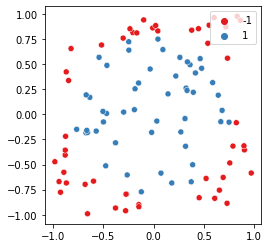

In [62]:
#@title SVM demonstration

# Generate a nonlinearly separable dataset

# Circle dataset
X = np.random.rand(100, 2) * 2 - 1
Y = (X ** 2).sum(-1) < (2 / np.pi)
Y = Y * 2 - 1

XGrid, XGridFlat = get_grid(X)
plot_data(X, Y)

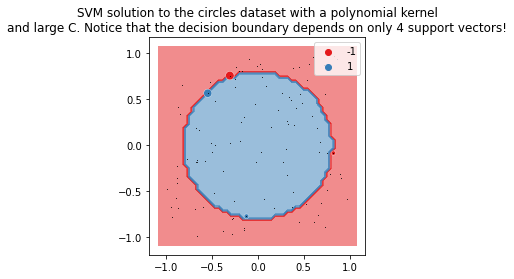

In [74]:
import sklearn.svm

# SVC stands for Support Vector Classifier which is another name
# for the SVM, i.e. the Support Vector Machine
# sklearn also provides SVR - a Support Vector Regressor
svm = sklearn.svm.SVC(C=10000000.0, kernel='poly', degree=2)
svm.fit(X, Y)

plot_data(
    X[svm.support_], Y[svm.support_], 
    np.abs(svm.dual_coef_[0]) * 10, 
    XGrid, svm.predict(XGridFlat))
plt.scatter(X[:,0], X[:,1], s=1, c='black', edgecolors='black', linewidths=0)
plt.title(
    f'SVM solution to the circles dataset with a polynomial kernel\n'
    f'and large C. Notice that the decision boundary depends on only {len(svm.support_)} support vectors!')
None

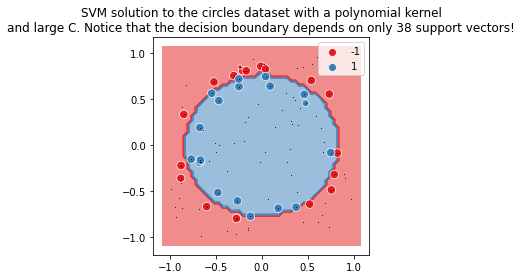

In [67]:
svm = sklearn.svm.SVC(C=1.0, kernel='poly', degree=2)
svm.fit(X, Y)

plot_data(
    X[svm.support_], Y[svm.support_], 
    np.abs(svm.dual_coef_[0]) * 10, 
    XGrid, svm.predict(XGridFlat))
plt.scatter(X[:,0], X[:,1], s=1, c='black', edgecolors='black', linewidths=0)
plt.title(
    f'SVM solution to the circles dataset with a polynomial kernel\n'
    f'and small C. Notice that the decision boundary depends on {len(svm.support_)} support vectors!')
None

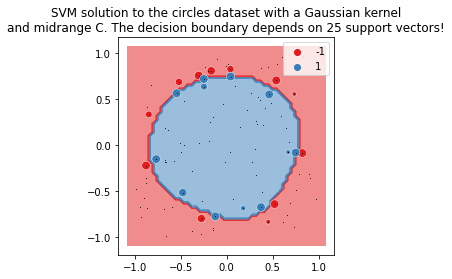

In [71]:
svm = sklearn.svm.SVC(C=10.0, kernel='rbf')
svm.fit(X, Y)

plot_data(
    X[svm.support_], Y[svm.support_], 
    np.abs(svm.dual_coef_[0]) * 10, 
    XGrid, svm.predict(XGridFlat))
plt.scatter(X[:,0], X[:,1], s=1, c='black', edgecolors='black', linewidths=0)
plt.title(
    f'SVM solution to the circles dataset with a Gaussian kernel\n'
    f'and midrange C. The decision boundary depends on {len(svm.support_)} support vectors!')
None

## Lecture summary

We have explored during todays lecture how simple classifiers can be appied to complex tasks using feature expansion techniques.

We have then seen that the feature expansion can be learned, using e.g. Bossting or Deep Learning techiques.

However, we can also use a fixed feature expanstion and only tune its hyperparameters. A particularly popular scheme is provided by Kernel Methods, which implicitly transform the data into a highly dimensional space. Even though the kernel transromation is fixed, it is often so rich that a classifier can be fited in this extended space. 

Finally, we note that the Kernelized models had the number of learned parameters proportional to the size of the training dataset. This brought them closer to neares neighbor techniques!

This last point is formalized in the notion of _parametric_ and _non-parametric_ machine learning methods. Intuitively, a parametric method builds a model whise size does not depend on the amount of training data. Examples include non-kernelized regression models, or the Naive Bayes classifier with a fixed vocabulary. Paramteric models offer good performance if they paramtric mode family that they describe contains a model which is close to the real relationship in the data. Otherwise, their performance tends to saturate whan all their parameters are fitted.

On the ther hand, the size of non-parametric models grows with the amount of training data. Examples we know include nearest neighbor methods (we must remember all examples), tress (with more dtaa the trees grow deeper) and kernelized models (they store a parameter for each data sample). Since non-parametric models grow with the amount of training data, their performance typically always improves with the amount of data. However, especially for small datasets, the rate of performance improvement with the amount of data can be smaller than for matched parametric models.

Finally, we observe that neural networks seem to be paramteric (the size of a single network doesn't grow with the size of the data), but if we tunde the size of the network a data-dependent choice, they tend ot grow with the amount of the training data as well. Thus they can be treated as non-parametric. Somewhat surprisingly, very large networks may be easier to train and reach better performance than smaller ones, a phenomenon known as deep double descent (see [ref1](https://www.pnas.org/content/116/32/15849) and [ref2](https://openai.com/blog/deep-double-descent/)). For more intuitions about Deep Learning models in invite you to my Deep Learning class in the next semester.